In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb

import shap
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import clone

from processing_functions import *

In [2]:
pd.set_option('display.max_colwidth', None)
df = pd.read_csv('data/input_file.csv')
#nan_percentage(df) 

## Processing

There is a lot of data missing for how people think others perceive them, and what attributes they think the rest of their sex prefer. 

Since I am also going to be working with no gender, I will drop any column related to the binary separation of gender.

The attribute that overall has the most amount of missing data is 'shared interests'. I was hoping to use this attribute as a reliable feature to find partners, but based on the findings made in the EDA it is the feature that is the least important. 

In [3]:
def drop_columns(df, suffix):
    cols = [col for col in df.columns if any(col.endswith(s) for s in suffix)]
    
    df = df.drop(columns=cols, errors='ignore')
    
    return df
    

suffix= ['_fellow_want', 'perceived', '_o_want', '_diff']
df = drop_columns(df, suffix)
df_final = df.drop(columns=['Unnamed: 0'])
df_pred = df_final.copy(deep=True)

Since there are too many people and waves in this experiment, I am going to opt to drop the rows that have nan values so that it is easier to work with when it comes to training the dataset (especially with Random Forest). 

In [4]:
df_final.head()

,iid,id,wave,partner,pid,match,int_corr,age_o,pf_o_att,pf_o_sin,...,amb_self,dec,attr,sinc,intel,fun,amb,shar,like,prob
0,1,1.0,1,1,11.0,0,0.14,27.0,35.0,20.0,...,7.0,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,1,1.0,1,2,12.0,0,0.54,22.0,60.0,0.0,...,7.0,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0
2,1,1.0,1,3,13.0,1,0.16,22.0,19.0,18.0,...,7.0,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN
3,1,1.0,1,4,14.0,1,0.61,23.0,30.0,5.0,...,7.0,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0
4,1,1.0,1,5,15.0,1,0.21,24.0,30.0,10.0,...,7.0,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0


In [5]:
df_final = df_final.dropna()
print(df_final.columns)

Index(['iid', 'id', 'wave', 'partner', 'pid', 'match', 'int_corr', 'age_o',
       'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
       'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o',
       'like_o', 'prob_o', 'age', 'imprelig', 'goal', 'date', 'go_out',
       'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking',
       'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts',
       'music', 'shopping', 'yoga', 'exphappy', 'expnum', 'attr_important',
       'sinc_important', 'intel_important', 'fun_important', 'amb_important',
       'shar_important', 'attr_self', 'sinc_self', 'fun_self', 'intel_self',
       'amb_self', 'dec', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar',
       'like', 'prob'],
      dtype='object')


In [6]:
# Dropping identifier columns and irrelevant features for prediction
df = df_final.drop(columns=['iid', 'id', 'pid', 'partner', 'wave'], axis=1)

In [7]:
df.head()

,match,int_corr,age_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,...,amb_self,dec,attr,sinc,intel,fun,amb,shar,like,prob
0,0,0.14,27.0,35.0,20.0,20.0,20.0,0.0,5.0,0,...,7.0,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,0,0.54,22.0,60.0,0.0,0.0,40.0,0.0,0.0,0,...,7.0,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0
3,1,0.61,23.0,30.0,5.0,15.0,40.0,5.0,5.0,1,...,7.0,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0
4,1,0.21,24.0,30.0,10.0,20.0,10.0,10.0,20.0,1,...,7.0,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0
5,0,0.25,25.0,50.0,0.0,30.0,10.0,0.0,10.0,1,...,7.0,0,4.0,9.0,7.0,4.0,6.0,4.0,6.0,5.0


## Models training

In [8]:
X = df.drop(['match', 'dec', 'dec_o'], axis=1)
y = df['match']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [9]:
# Start by modelling a LightGBM and Random Forest model 
# Will do comparison of both and decide based on 
# maybe can try to use LightGBM but using 'random forest' as the boosting_type(?)

lgb_model = lgb.LGBMClassifier(random_state=42, verbose=-1)
rf_model = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)

lgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [10]:
rf_accuracy = cross_val_score(rf_model, X_train, y_train, cv=5)
lgb_accuracy = cross_val_score(lgb_model, X_train, y_train, cv=5)
xgb_accuracy = cross_val_score(xgb_model, X_train, y_train, cv=5)

print("Random Forest Accuracy: ", rf_accuracy.mean())
print("LightGBM Accuracy: ", lgb_accuracy.mean())
print("XGBClassifier Accuracy: ", xgb_accuracy.mean())

Random Forest Accuracy:  0.8533333333333333
LightGBM Accuracy:  0.8573333333333333
XGBClassifier Accuracy:  0.844


In [11]:
# Comparison between models with classification_report
# Make prediction on the testing data
y_pred_rf = rf_model.predict(X_test)
y_pred_lgb = lgb_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Classification Report
print("RandomForestClassifier:\n", classification_report(y_test, y_pred_rf, zero_division=0))
print("LightGBM:\n", classification_report(y_pred_lgb, y_test))
print("XGBClassifer:\n", classification_report(y_pred_xgb, y_test))

print("\n")

# F1 Score
print("RandomForestClassifier F1 score:\n", f1_score(y_test, y_pred_rf, zero_division=0, average="weighted"),"\n")
print("LightGBM F1 score:\n", f1_score(y_pred_lgb, y_test, average="weighted"),"\n")
print("XGBClassifer F1 score:\n", f1_score(y_pred_xgb, y_test, average="weighted"))

RandomForestClassifier:
               precision    recall  f1-score   support

           0       0.88      0.98      0.92       208
           1       0.75      0.35      0.48        43

    accuracy                           0.87       251
   macro avg       0.81      0.66      0.70       251
weighted avg       0.86      0.87      0.85       251

LightGBM:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       213
           1       0.56      0.63      0.59        38

    accuracy                           0.87       251
   macro avg       0.75      0.77      0.76       251
weighted avg       0.88      0.87      0.87       251

XGBClassifer:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       217
           1       0.56      0.71      0.62        34

    accuracy                           0.88       251
   macro avg       0.76      0.81      0.78       251
weighted avg       0.90

### Threshold computation

In [12]:
df['match'].value_counts(normalize=True)

0    0.800319
1    0.199681
Name: match, dtype: float64

After looking at the accuracy and the other metrics we can see that, same as had previously measured in the EDA, this is a very unbalanced dataset. Almost 80% of the values belong to 0, while only 20% is part of the positive results.

There is a much higher number of 0s (no matches) than 1s (matches), there this makes the precision, accuracy and recall of the matches much more lower than the no matches.

We need to find a weight balance in order to work with it and in return choose the most appropriate model to work with.
References found in: [https://stackoverflow.com/questions/51190809/high-auc-but-bad-predictions-with-imbalanced-data]

We might also want to look into the performance of a =XGBoost= model since it performs better for unbalanced data. 
The boosting algorithm iteratively learns from the mistakes of the previous tree. So if a tree fails to predict a class (most likely the imbalanced class), the proceeding tree will give more weightage to this sample.

In [13]:
def pr_threshold(model, model_name='Model'):
    """
    Calculate and plot the precision-recall curve for a given model and test data.
    Also, find the threshold that yields the highest F1 score using an iterative method and plot the classification report based on this threshold.

    Returns:
    optimal_threshold: The threshold value that yields the highest F1 score.
    optimal_report: Classification report using the optimal threshold.
    """
    # probabilities for the positive class
    probabilities = model.predict_proba(X_val)[:,1]

    # precision, recall, and thresholds using the predicted probabilities
    precision, recall, thresholds = precision_recall_curve(y_val, probabilities)

    # F1 score for each threshold with tiny constant to avoid division by zero
    fscore = (2 * precision * recall) / (precision + recall + 1e-12)

    # Find the index of the maximum F1 score
    optimal_index = np.argmax(fscore)
    best_threshold = thresholds[optimal_index]

    # Make final predictions using the optimal threshold
    final_predictions = (model.predict_proba(X_test)[:,1] >= best_threshold).astype(int)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
    plt.plot(thresholds, (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-12), 'r-.', label='F1 Score')
    plt.axvline(x=best_threshold, color='k', linestyle='--', label='Optimal Threshold')
    plt.xlabel('Threshold')
    plt.legend(loc='best')
    plt.ylim([0, 1])
    plt.title(f'{model_name}: Precision, Recall, and F1 Score for different thresholds')
    plt.show()

    optimal_report = classification_report(y_test, final_predictions, zero_division=0)
    return best_threshold, optimal_report

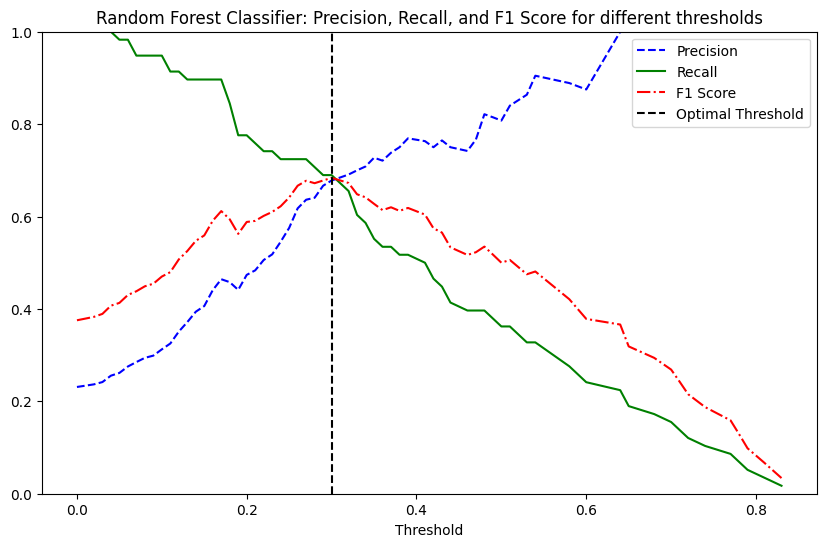

Optimal threshold for maximum Random Forest F1-score: 0.3
Using threshold ~0.3000 for evaluation.

              precision    recall  f1-score   support

           0       0.93      0.84      0.88       208
           1       0.47      0.67      0.55        43

    accuracy                           0.81       251
   macro avg       0.70      0.76      0.72       251
weighted avg       0.85      0.81      0.83       251
 

Random Forest: f1 score 0.8890810551048869


In [14]:
optimal_threshold_rf, optimal_report_rf = pr_threshold(rf_model, model_name='Random Forest Classifier')

print("Optimal threshold for maximum Random Forest F1-score:", optimal_threshold_rf)
print(f"Using threshold ~{optimal_threshold_rf:.4f} for evaluation.\n")
print(optimal_report_rf, "\n")

final_predictions_rf = (rf_model.predict(X_test) >= 0.3).astype(int)
print("Random Forest: f1 score", f1_score(final_predictions_rf, y_test, average="weighted"))

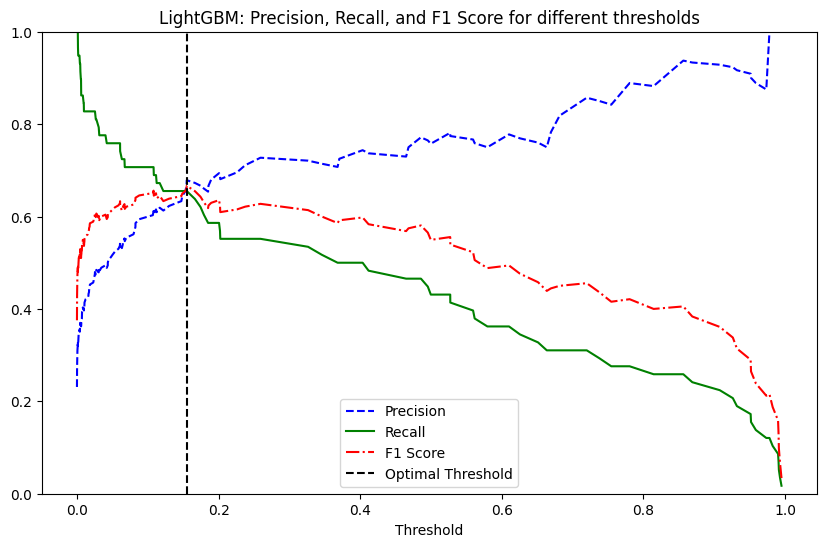

Optimal threshold for maximum LightGBM F1-score: 0.155051421246994
Using threshold ~0.1551 for evaluation.

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       208
           1       0.46      0.63      0.53        43

    accuracy                           0.81       251
   macro avg       0.69      0.74      0.70       251
weighted avg       0.84      0.81      0.82       251

LightGBM: F1 score 0.871803014036929


In [15]:
optimal_threshold_lgb, optimal_report_lgb = pr_threshold(lgb_model, model_name='LightGBM')

print("Optimal threshold for maximum LightGBM F1-score:", optimal_threshold_lgb)
print(f"Using threshold ~{optimal_threshold_lgb:.4f} for evaluation.\n")
print(optimal_report_lgb)

final_predictions_lgb = (lgb_model.predict(X_test) >= optimal_threshold_lgb).astype(int)
print("LightGBM: F1 score", f1_score(final_predictions_lgb, y_test, average="weighted"))

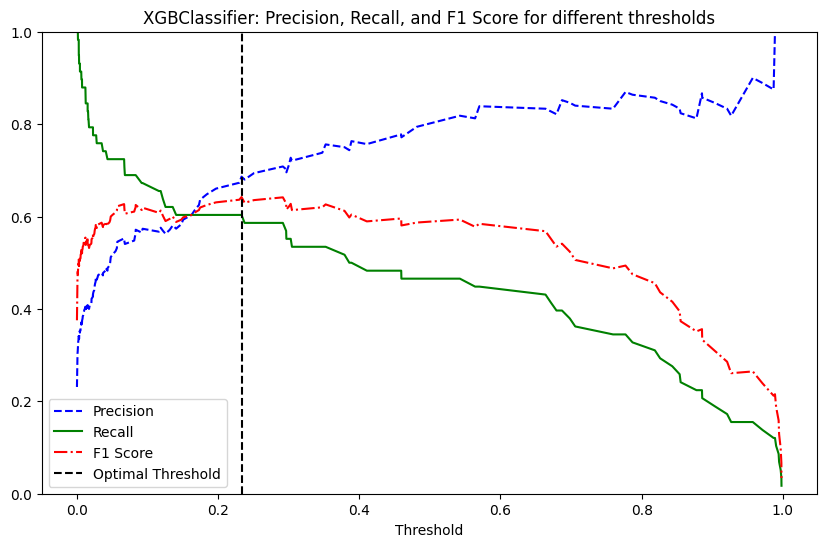

Optimal threshold for maximum XGBClassifier F1-score: 0.23315626
Using threshold ~0.2332 for evaluation.

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       208
           1       0.49      0.63      0.55        43

    accuracy                           0.82       251
   macro avg       0.70      0.75      0.72       251
weighted avg       0.85      0.82      0.83       251

XGBClassifier: F1 score 0.889991021399505


In [16]:
optimal_threshold_xgb, optimal_report_xgb = pr_threshold(xgb_model, model_name='XGBClassifier')

print("Optimal threshold for maximum XGBClassifier F1-score:", optimal_threshold_xgb)
print(f"Using threshold ~{optimal_threshold_xgb:.4f} for evaluation.\n")
print(optimal_report_xgb)

final_predictions_xgb = (xgb_model.predict(X_test) >= optimal_threshold_xgb).astype(int)
print("XGBClassifier: F1 score", f1_score(final_predictions_xgb, y_test, average="weighted"))

### SHAP Values Computation

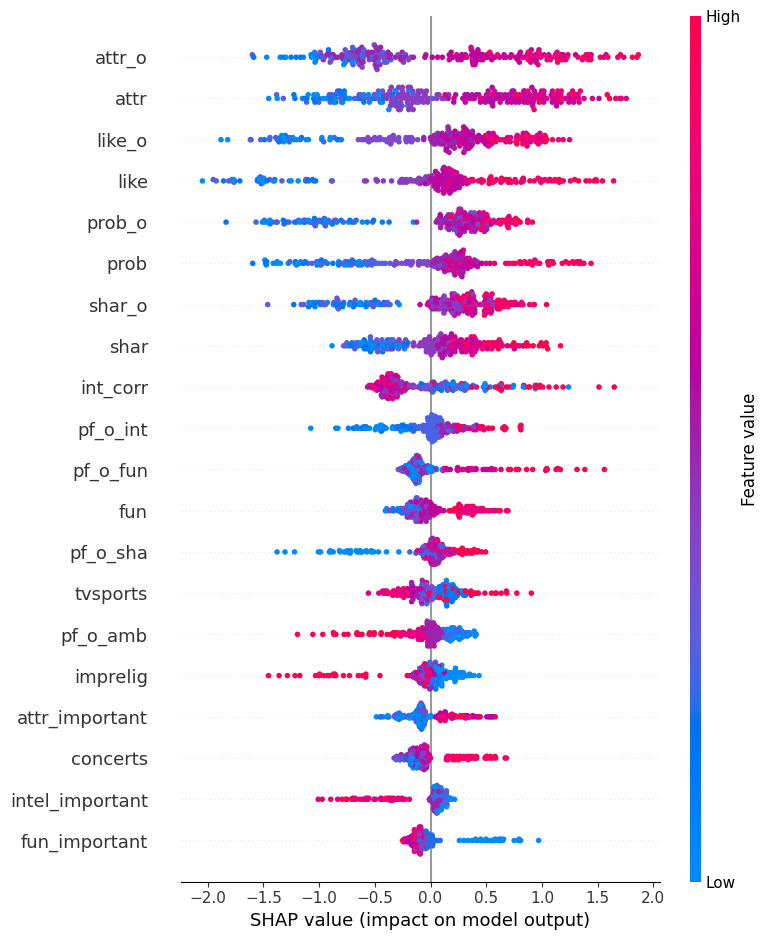

In [17]:
explainer = shap.Explainer(lgb_model, X_train)
shap_values_lgb = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values_lgb, X_test)

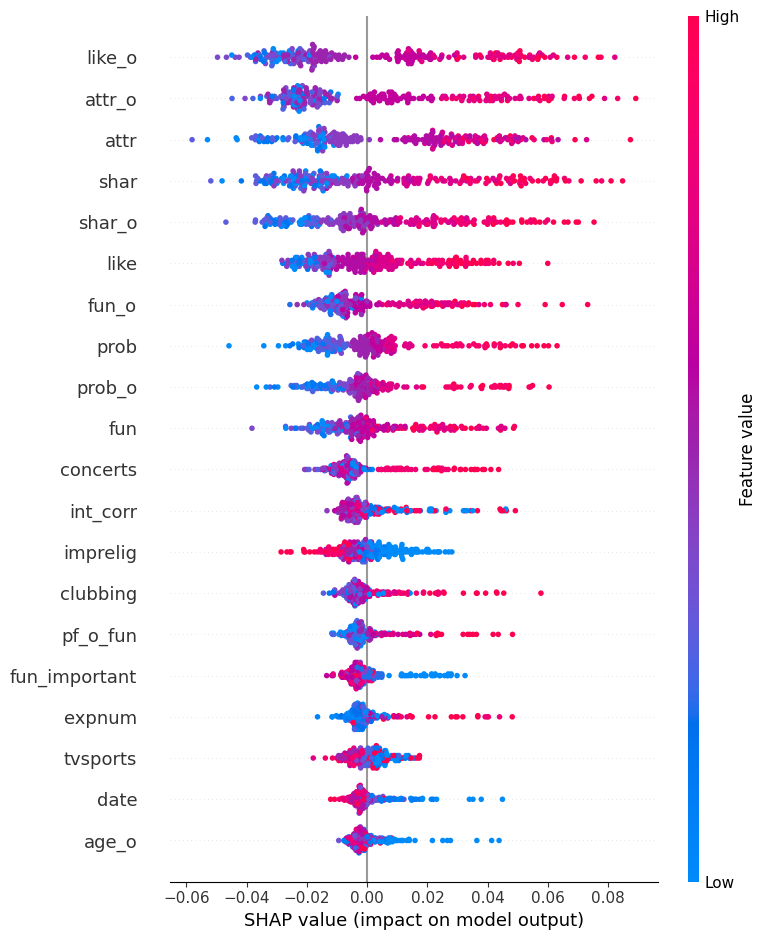

In [18]:
explainer = shap.Explainer(rf_model, X_train)
shap_values_rf = explainer.shap_values(X_test, check_additivity=False)

# Visualize the SHAP values
shap.summary_plot(shap_values_rf[1], X_test)

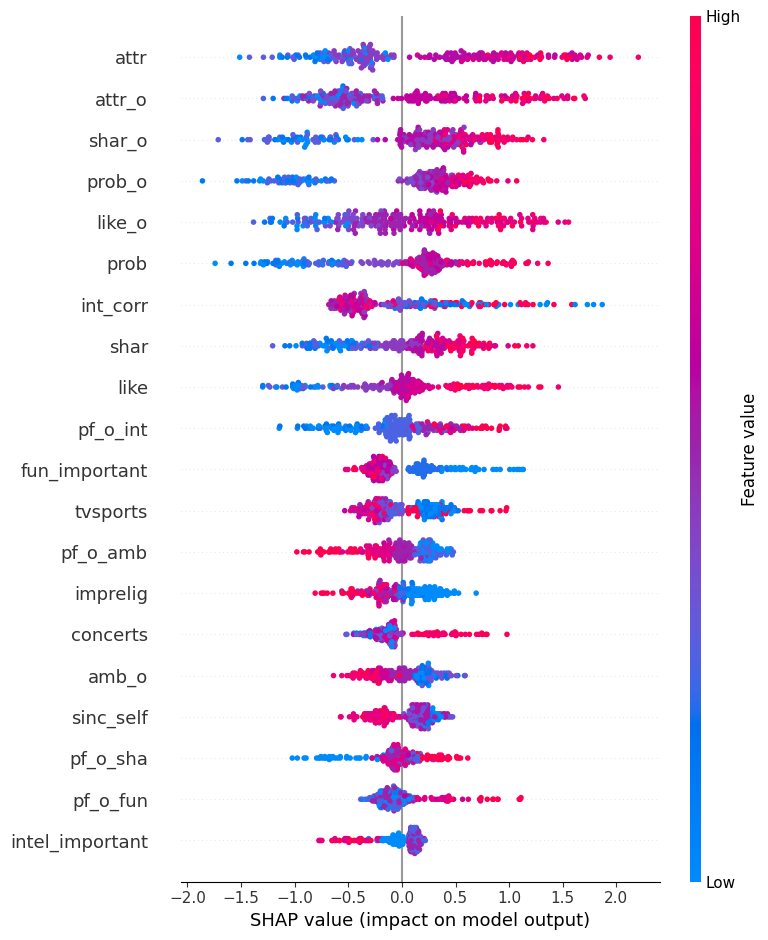

In [19]:
explainer = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values_xgb, X_test)

In [20]:
def shap_importance(model, shap_values):
    """
    Return a dataframe containing the features sorted by Shap importance.

    Parameters:
    model : The tree-based model (like RandomForest, XGBoost, etc.).

    Returns:
    pd.DataFrame
        A dataframe containing the features sorted by Shap importance.
    """
    # explainer = shap.Explainer(model, X_train)
    
    # shap_values = explainer.shap_values(X_test, check_additivity=False)
    
    if isinstance(shap_values, list):
        shap_values = np.abs(shap_values[1])
    else:
        shap_values = np.abs(shap_values)
        
    mean_abs_shap_values = shap_values.mean(axis=0)
    
    feature_importance = pd.DataFrame({
        'features': X_test.columns,
        'importance': mean_abs_shap_values
    })
    
    feature_importance.sort_values(by='importance', ascending=False, inplace=True)
    return feature_importance.reset_index(drop=True).head(30)

top_features = shap_importance(xgb_model, shap_values_rf).drop([0, 26, 19, 11, 5, 16])

In [21]:
top_features

,features,importance
1,attr_o,0.025604
2,attr,0.025145
3,shar,0.024328
4,shar_o,0.020584
6,fun_o,0.013630
7,prob,0.013470
8,prob_o,0.011792
9,fun,0.011731
10,concerts,0.009877
12,imprelig,0.007588


In [50]:
shap_columns = top_features['features'].to_list()
shap_features = df_wave[shap_columns]
print(shap_features)

     attr_o  attr  shar  shar_o  fun_o  prob  prob_o  fun  concerts  imprelig  \
0       6.0   6.0   5.0     6.0    8.0   6.0     4.0  7.0  1.705304  0.424903   
1       7.0   7.0   6.0     5.0    7.0   5.0     4.0  8.0  1.705304  0.424903   
4       8.0   5.0   6.0     7.0    6.0   6.0     6.0  7.0  1.705304  0.424903   
5       7.0   4.0   4.0     7.0    8.0   5.0     6.0  4.0  1.705304  0.424903   
6       3.0   7.0   7.0     7.0    5.0   5.0     1.0  4.0  1.705304  0.424903   
..      ...   ...   ...     ...    ...   ...     ...  ...       ...       ...   
222     5.0   8.0   7.0     5.0    5.0   4.0     5.0  7.0  0.133924 -0.319206   
227     2.0   3.0   2.0     1.0    2.0   1.0     1.0  4.0  0.133924 -0.319206   
228     4.0   3.0   4.0     5.0    6.0   2.0     2.0  5.0  0.133924 -0.319206   
229     6.0   7.0   8.0     6.0    7.0   5.0     5.0  6.0  0.133924 -0.319206   
230     4.0   4.0   4.0     5.0    6.0   2.0     4.0  4.0  0.133924 -0.319206   

     ...      date  pf_o_at

## Chosen wave data preparation

In [22]:
print(df_final['iid'].unique())
df_final.to_csv('data/clean_data.csv')

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37
  38  39  40  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 115 116 117 119 120 121 122 123 124 125 126 127 128 130 131]


In [23]:
df_final[df_final['wave'] == 1]

,iid,id,wave,partner,pid,match,int_corr,age_o,pf_o_att,pf_o_sin,...,amb_self,dec,attr,sinc,intel,fun,amb,shar,like,prob
0,1,1.0,1,1,11.0,0,0.14,27.0,35.00,20.00,...,7.0,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,1,1.0,1,2,12.0,0,0.54,22.0,60.00,0.00,...,7.0,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0
3,1,1.0,1,4,14.0,1,0.61,23.0,30.00,5.00,...,7.0,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0
4,1,1.0,1,5,15.0,1,0.21,24.0,30.00,10.00,...,7.0,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0
5,1,1.0,1,6,16.0,0,0.25,25.0,50.00,0.00,...,7.0,0,4.0,9.0,7.0,4.0,6.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,20,10.0,1,6,6.0,0,0.43,23.0,10.00,25.00,...,10.0,0,7.0,10.0,10.0,6.0,10.0,7.0,6.0,7.0
196,20,10.0,1,7,7.0,0,-0.16,22.0,15.00,15.00,...,10.0,0,7.0,6.0,8.0,6.0,8.0,7.0,7.0,7.0
197,20,10.0,1,8,8.0,1,-0.21,25.0,9.09,18.18,...,10.0,1,8.0,10.0,9.0,9.0,8.0,8.0,8.0,8.0
198,20,10.0,1,9,9.0,0,-0.23,26.0,20.00,10.00,...,10.0,0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0


#### Matches per wave

In [24]:
def wave_matches_display(df):
    # Dictionary to store data for each wave
    wave_data = {}

    # Group by wave and process each group
    for wave, group in df.groupby('wave'):
        # Collect all participants in the wave
        participants = list(group['iid'].unique())
        
        # Collect matches as lists of pairs
        matches = []
        for index, person in group.iterrows():
            if person['match'] == 1 and person['pid'] in group['iid'].values:
                matches.append([person['iid'], person['pid']])
        
        # Storing results in the dictionary with wave as key
        wave_data[wave] = {
            "participants": participants,
            "matches": matches
        }

    # Convert the dictionary into a DataFrame
    wave_df = pd.DataFrame([
        {'wave': wave, 'participants': data['participants'], 'matches': data['matches']}
        for wave, data in wave_data.items()
    ])

    return wave_df

wave_df = wave_matches_display(df_final)
wave_df_pred = wave_matches_display(df_pred)

In [25]:
wave_df

,wave,participants,matches
0,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]","[[1.0, 14.0], [1.0, 15.0], [1.0, 19.0], [2.0, 14.0], [2.0, 19.0], [4.0, 14.0], [4.0, 19.0], [5.0, 14.0], [5.0, 19.0], [6.0, 14.0], [6.0, 19.0], [7.0, 14.0], [7.0, 19.0], [8.0, 12.0], [8.0, 13.0], [8.0, 14.0], [8.0, 16.0], [8.0, 18.0], [8.0, 19.0], [8.0, 20.0], [9.0, 12.0], [9.0, 13.0], [9.0, 14.0], [9.0, 15.0], [9.0, 16.0], [9.0, 17.0], [9.0, 19.0], [10.0, 19.0], [12.0, 8.0], [12.0, 9.0], [13.0, 8.0], [13.0, 9.0], [14.0, 1.0], [14.0, 2.0], [14.0, 4.0], [14.0, 5.0], [14.0, 6.0], [14.0, 7.0], [14.0, 8.0], [14.0, 9.0], [15.0, 1.0], [15.0, 9.0], [16.0, 8.0], [16.0, 9.0], [17.0, 9.0], [18.0, 8.0], [19.0, 1.0], [19.0, 2.0], [19.0, 4.0], [19.0, 5.0], [19.0, 6.0], [19.0, 7.0], [19.0, 8.0], [19.0, 9.0], [19.0, 10.0], [20.0, 8.0]]"
1,2,"[21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]","[[22.0, 44.0], [22.0, 45.0], [23.0, 43.0], [23.0, 44.0], [23.0, 45.0], [27.0, 46.0], [29.0, 44.0], [29.0, 45.0], [30.0, 55.0], [31.0, 55.0], [34.0, 49.0], [35.0, 45.0], [35.0, 46.0], [35.0, 49.0], [35.0, 53.0], [36.0, 49.0], [36.0, 51.0], [37.0, 44.0], [37.0, 52.0], [38.0, 49.0], [38.0, 55.0], [39.0, 47.0], [43.0, 23.0], [44.0, 22.0], [44.0, 23.0], [44.0, 29.0], [44.0, 37.0], [45.0, 22.0], [45.0, 23.0], [45.0, 29.0], [45.0, 35.0], [46.0, 27.0], [46.0, 35.0], [47.0, 39.0], [49.0, 34.0], [49.0, 35.0], [49.0, 36.0], [49.0, 38.0], [51.0, 36.0], [52.0, 37.0], [53.0, 35.0], [55.0, 30.0], [55.0, 31.0], [55.0, 38.0]]"
2,3,"[56, 57, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]","[[56.0, 70.0], [57.0, 71.0], [61.0, 71.0], [61.0, 75.0], [62.0, 67.0], [62.0, 74.0], [63.0, 67.0], [64.0, 75.0], [67.0, 62.0], [67.0, 63.0], [70.0, 56.0], [71.0, 57.0], [71.0, 61.0], [74.0, 62.0], [75.0, 61.0], [75.0, 64.0]]"
3,4,"[76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111]","[[77.0, 94.0], [77.0, 97.0], [77.0, 99.0], [77.0, 105.0], [77.0, 107.0], [78.0, 107.0], [78.0, 109.0], [79.0, 107.0], [79.0, 108.0], [80.0, 102.0], [80.0, 105.0], [80.0, 109.0], [81.0, 99.0], [81.0, 104.0], [81.0, 108.0], [82.0, 94.0], [82.0, 99.0], [82.0, 105.0], [82.0, 107.0], [82.0, 109.0], [83.0, 99.0], [83.0, 107.0], [84.0, 105.0], [84.0, 108.0], [85.0, 107.0], [86.0, 97.0], [86.0, 100.0], [86.0, 104.0], [86.0, 105.0], [86.0, 107.0], [86.0, 108.0], [86.0, 109.0], [86.0, 110.0], [87.0, 99.0], [87.0, 107.0], [89.0, 99.0], [89.0, 104.0], [90.0, 109.0], [92.0, 97.0], [92.0, 99.0], [92.0, 105.0], [92.0, 107.0], [92.0, 109.0], [93.0, 95.0], [93.0, 100.0], [93.0, 104.0], [94.0, 77.0], [94.0, 82.0], [95.0, 93.0], [97.0, 77.0], [97.0, 86.0], [97.0, 92.0], [99.0, 77.0], [99.0, 81.0], [99.0, 82.0], [99.0, 83.0], [99.0, 87.0], [99.0, 89.0], [99.0, 92.0], [100.0, 86.0], [100.0, 93.0], [102.0, 80.0], [104.0, 81.0], [104.0, 86.0], [104.0, 89.0], [104.0, 93.0], [105.0, 77.0], [105.0, 80.0], [105.0, 82.0], [105.0, 84.0], [105.0, 86.0], [105.0, 92.0], [107.0, 77.0], [107.0, 78.0], [107.0, 79.0], [107.0, 82.0], [107.0, 83.0], [107.0, 85.0], [107.0, 86.0], [107.0, 87.0], [107.0, 92.0], [108.0, 79.0], [108.0, 81.0], [108.0, 84.0], [108.0, 86.0], [109.0, 78.0], [109.0, 80.0], [109.0, 82.0], [109.0, 86.0], [109.0, 90.0], [109.0, 92.0], [110.0, 86.0]]"
4,5,"[112, 113, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131]","[[112.0, 122.0], [112.0, 125.0], [112.0, 126.0], [112.0, 127.0], [112.0, 128.0], [113.0, 125.0], [113.0, 126.0], [113.0, 128.0], [115.0, 125.0], [115.0, 127.0], [115.0, 128.0], [116.0, 122.0], [116.0, 125.0], [116.0, 127.0], [117.0, 125.0], [119.0, 125.0], [119.0, 127.0], [120.0, 122.0], [120.0, 125.0], [120.0, 128.0], [122.0, 112.0], [122.0, 116.0], [122.0, 120.0], [125.0, 112.0], [125.0, 113.0], [125.0, 115.0], [125.0, 116.0], [125.0, 117.0], [125.0, 119.0], [125.0, 120.0], [126.0, 

#### Preparation of first wave dataframe

In [27]:
def indices_column(df, value):
    filtered_df = df[df['wave'] == value]
    indices = filtered_df.index.tolist()
    return indices

# select rows from another dataframe using the obtained indices
def select_rows(df, indices):
    return df.iloc[indices]

indices = indices_column(df_final, 1)
df_wave = select_rows(df_final, indices)
df_wave = df_wave.drop(columns=['id', 'partner', 'wave', 'age_o', 'expnum'], axis=1)
# df_wave = df_wave.drop(df_wave[df_wave['iid'] == 21].index)
# df_wave = df_wave.drop(df_wave[df_wave['iid'] == 22].index)
#print(indices)

In [28]:
df_wave['like']

0      7.0
1      7.0
4      6.0
5      6.0
6      6.0
      ... 
222    7.0
227    2.0
228    2.0
229    8.0
230    4.0
Name: like, Length: 176, dtype: float64

### Preparing distinct dataframes for Preference Lists

In [30]:
attributes = [
    'iid', 
    'attr_o', 
    'sinc_o',
    'intel_o', 
    'fun_o', 
    'amb_o', 
    'shar_o',    
    # 'attr_self', 
    # 'sinc_self', 
    # 'intel_self', 
    # 'fun_self', 
    # 'amb_self'
]

attributes_averages = df_wave[attributes].groupby('iid').mean().reset_index()
print(attributes_averages)

# df_wave['goal'].value_counts()

    iid    attr_o    sinc_o   intel_o     fun_o     amb_o    shar_o
0     1  6.250000  7.000000  7.625000  6.750000  7.625000  6.625000
1     2  7.700000  7.100000  7.900000  7.500000  7.500000  6.500000
2     3  6.833333  7.166667  7.833333  6.333333  7.500000  6.166667
3     4  7.000000  7.100000  7.700000  7.500000  7.700000  7.200000
4     5  5.300000  7.700000  7.600000  7.200000  7.800000  6.200000
5     6  6.800000  7.800000  8.600000  7.000000  8.000000  6.300000
6     7  7.900000  7.600000  8.200000  7.000000  7.500000  6.700000
7     8  8.125000  7.750000  8.125000  7.500000  7.375000  6.375000
8     9  7.000000  7.400000  7.500000  7.800000  6.900000  6.300000
9    10  6.500000  6.500000  6.500000  6.500000  6.000000  6.000000
10   11  5.500000  8.000000  7.500000  5.500000  6.000000  4.000000
11   12  7.875000  7.125000  7.875000  7.250000  7.875000  6.125000
12   13  4.714286  7.857143  8.714286  6.285714  6.000000  5.857143
13   14  8.142857  7.428571  7.000000  7.285714 

In [31]:
def goal_mapping(df):
    # First, create a mapping dictionary for the 'goal' values
    mapping = {
        1: 1, 2: 1,
        3: 2, 4: 2,
        5: 3, 6: 3
    }

    # Aggregate the DataFrame by 'iid' and take the first 'goal' from each group
    aggregated_df = df.groupby('iid').agg({'goal': 'first'}).reset_index()

    # Apply the mapping to the 'goal' column and create a new column for remapped values
    aggregated_df['goal'] = aggregated_df['goal'].map(mapping).fillna(aggregated_df['goal'])

    return aggregated_df

goals = goal_mapping(df_wave)
attributes_averages = pd.concat([attributes_averages, goals['goal']], axis=1)
attributes_averages.head()

,iid,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,goal
0,1,6.250000,7.000000,7.625000,6.750000,7.625,6.625000,1
1,2,7.700000,7.100000,7.900000,7.500000,7.500,6.500000,1
2,3,6.833333,7.166667,7.833333,6.333333,7.500,6.166667,3
3,4,7.000000,7.100000,7.700000,7.500000,7.700,7.200000,1
4,5,5.300000,7.700000,7.600000,7.200000,7.800,6.200000,1


In [32]:
importance = df_wave[[
    'iid',
    'attr_important', 
    'sinc_important', 
    'intel_important',
    'fun_important', 
    'amb_important', 
    'shar_important'
]]

importance = importance.groupby('iid').mean().round().astype(int)
importance = importance.apply(lambda x: np.clip(x, 1, 6))

def resolve_conflicts(row):
    # Sort row values and get indices of the sorted elements
    sorted_indices = np.argsort(row)
    ranks = np.arange(1, 7)

    # Assign ranks according to the sorted indices (smallest value gets rank 1, largest gets rank N)
    sorted_row = np.empty_like(ranks)
    sorted_row[sorted_indices] = ranks

    return pd.Series(sorted_row, index=row.index)

importance_attributes = importance.apply(resolve_conflicts, axis=1).reset_index()
importance_attributes = pd.concat([importance_attributes, goals['goal']], axis=1)
importance_attributes

,iid,attr_important,sinc_important,intel_important,fun_important,amb_important,shar_important,goal
0,1,5,2,1,3,6,4,1
1,2,1,4,2,3,6,5,1
2,3,1,3,2,4,5,6,3
3,4,3,1,2,4,5,6,1
4,5,3,6,2,1,5,4,1
5,6,5,2,3,1,6,4,1
6,7,3,4,1,2,5,6,1
7,8,5,2,1,3,4,6,1
8,9,2,4,3,1,5,6,1
9,10,4,2,3,1,5,6,1


In [33]:
date_rankings = df_wave[['iid', 'pid', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar']]
shared = df_wave[[
    'iid',
    'sports', 
    'tvsports', 
    'exercise', 
    'dining', 
    'museums', 
    'art', 
    'hiking', 
    'gaming', 
    'clubbing', 
    'reading', 
    'tv', 
    'theater', 
    'movies', 
    'concerts', 
    'music', 
    'shopping', 
    'yoga'
]].drop_duplicates()

### Grid Search for XGBoost Models 

Made two models with XGBoost:
- Classifier: to predict the matches once more so that these predictions can be added as a key component when creating and ranking the potential parter prederences lists

- Regressor: as a different way to find the preferences lists. This way the 'liking' (column 'like') prediction of each individual can give us their rank preference of everyone they went on a date with. Since some of them did not have dates with everyone or the information was missing, the rest of the subjects would be added in an ordered way.

In [34]:
X_class = df_wave[shap_columns]
y_class = df_wave['match']

X_reg = df_wave.drop(columns=['like', 'iid', 'pid', 'like_o']) 
y_reg = df_wave['like']

# Define a K-Fold cross-validator
kf = KFold(n_splits=3, shuffle=True, random_state=42) 

param_grid = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

param_grid_regressor = {
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.5, 0.1],
    'n_estimators': [100,500,1000],
    'max_depth': [3, 6 ,10],
    'colsample_bytree': [0.8, 1]
    
}

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search_xgb_classifier = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=kf, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_xgb_regressor = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid_regressor, cv=kf, verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search_xgb_classifier.fit(X_class, y_class)
grid_search_xgb_regressor.fit(X_reg, y_reg)

print("Best parameters found xgb_classifier:\n", grid_search_xgb_classifier.best_params_)
print("Best parameters found xgb_regressor:\n", grid_search_xgb_regressor.best_params_)

print("\n The best score across ALL searched params for xgb_regressor:",grid_search_xgb_regressor.best_score_)

print("\n The best score across ALL searched params for xgb_classifier:",grid_search_xgb_classifier.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estim

In [35]:
# Best classifier model predictions
#y_pred_cv = cross_val_predict(classifier, X_class, y_class, cv=kf)

best_model = grid_search_xgb_classifier.best_estimator_
y_pred = best_model.predict(X_class)

results_df = pd.DataFrame({
    'iid': df_wave['iid'],
    'pid': df_wave['pid'],
    'predicted_match': y_pred,
    'actual_match': y_class
})

In [36]:
df_wave['match_predictions'] = results_df['predicted_match']
attributes_averages['match_predictions'] = results_df['predicted_match']

df_wave.columns
attributes_averages.columns

Index(['iid', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o',
       'goal', 'match_predictions'],
      dtype='object')

In [51]:
# Prediction on best Regressor model
# cv_scores = cross_val_score(regressor, X_reg, y_reg, cv=kf, scoring='neg_mean_squared_error')

# Optionally, predict during cross-validation to analyze predictions
# y_pred_cv = cross_val_predict(regressor, X_reg, y_reg, cv=kf)

best_model = grid_search_xgb_regressor.best_estimator_
y_pred = best_model.predict(X_reg)

results_df = pd.DataFrame({
    'iid': df_wave['iid'],
    'pid': df_wave['pid'].astype(int),
    'predicted_like': y_pred,
    'actual_like': y_reg
})

results_df.sort_values(by=['iid', 'predicted_like'], ascending=[True, False], inplace=True)
preferences_predictions = results_df.groupby('iid')['pid'].apply(list).to_dict()
results_df

,iid,pid,predicted_like,actual_like
0,1,11,7.000155,7.0
1,1,12,6.999226,7.0
8,1,19,6.998963,7.0
6,1,17,6.031819,6.0
9,1,20,6.025565,6.0
...,...,...,...,...
219,22,43,4.004695,4.0
230,22,54,3.938884,4.0
218,22,42,3.035056,3.0
228,22,52,2.079612,2.0


## Preferences Lists for each subject

#### Preference Lists obtained with the data obtained from the dataset

In [37]:
def individual_preference(attributes_averages, importance, iid, date_rankings, df_wave):
    """
    Computes and ranks potential partners for a specified individual based on their preference weights, matching dating goals,
    individual rankings given during past dates, common interests, and the significance of those goals.
    
    Args:
    - attributes_averages (DataFrame): DataFrame containing averaged attributes and dating goals for each person.
    - importance (DataFrame): DataFrame containing the importance rankings for each attribute and dating goals for each person.
    - iid (int): The individual ID for whom to compute the scores.
    - date_rankings (DataFrame): DataFrame containing the rankings given by subjects to their dates across various attributes.
    - df_wave (DataFrame): DataFrame containing ratings for various activities and interests from 1 to 10.
    
    Returns:
    - DataFrame: A DataFrame of other persons ranked by compatibility for the specified individual.
    """
    if iid not in importance['iid'].values:
        return "Invalid iid. This individual does not exist in the importance dataset."

    # importance rankings and dating goal for the specified individual
    person_importance = importance.loc[importance['iid'] == iid].iloc[0]
    person_goal = person_importance['goal']

    # adjust importance rankings (now 6 most important, 1 least important) to be used as weights
    for attr in person_importance.index:
        if 'important' in attr:
            person_importance[attr] = 7 - person_importance[attr]

    # merging the date rankings for the iid into attributes_averages
    relevant_rankings = date_rankings[date_rankings['iid'] == iid]
    if not relevant_rankings.empty:
        relevant_rankings = relevant_rankings.set_index('pid')
        attributes_averages = attributes_averages.join(relevant_rankings, on='iid', how='left', rsuffix='_ranked')

    # Set up the wave data for interests calculation
    df_wave = df_wave.set_index('iid')
    #print(df_wave)
    subject_interests = df_wave.loc[iid]
    partner_interests = df_wave.loc[relevant_rankings.index]

    # Calculate common interests
    common_interests_columns = ['sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 
                                'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']
    common_interests_score = (partner_interests[common_interests_columns] >= 8) & (subject_interests[common_interests_columns] >= 8)
    common_interests_score = common_interests_score.sum(axis=1) * 5

    scores_df = attributes_averages.copy()
    scores_df['total_score'] = 0

    # weighted scores for attributes and replace NaN values where necessary
    for important_attr in person_importance.index:
        if 'important' in important_attr:
            observed_attr = important_attr.replace('_important', '') + '_o'
            ranked_attr = observed_attr.replace('_o', '') + '_ranked'
            if observed_attr in scores_df.columns:
                weighted_score = scores_df[observed_attr] * person_importance[important_attr]
                scores_df['total_score'] += weighted_score
                #if there are already ranked scores, add them (replace NaNs with attribute averages)
                if ranked_attr in scores_df.columns:
                    scores_df[ranked_attr] = scores_df[ranked_attr].fillna(scores_df[observed_attr])
                    scores_df['total_score'] += scores_df[ranked_attr] * person_importance[important_attr]

    # Add common interests score from the correctly indexed partner interests
    scores_df.loc[partner_interests.index, 'total_score'] += common_interests_score.fillna(0)

    # Apply goal matching boost
    goal_boost = 10
    scores_df['total_score'] += (scores_df['goal'] == person_goal) * goal_boost

    match_bonus = 5
    scores_df['total_score'] += scores_df['match_predictions'].fillna(0) * match_bonus

    # Remove the individual from the DataFrame, sort by total_score
    scores_df = scores_df.drop(index=iid-1)
    scores_df.sort_values('total_score', ascending=False, inplace=True)
    preference_list = scores_df['iid'].tolist()

    return preference_list

iids = range(1, 21)
for iid in iids:
    preference_list = individual_preference(attributes_averages, importance_attributes, iid, date_rankings, shared)
    print(f"Preference list for iid {iid}:\n{preference_list}\n")

Preference list for iid 1:
[20, 13, 12, 19, 8, 6, 14, 7, 9, 17, 2, 4, 5, 18, 21, 16, 15, 3, 11, 10, 22]

Preference list for iid 2:
[14, 20, 12, 19, 8, 7, 17, 9, 15, 6, 4, 21, 13, 5, 1, 16, 3, 18, 10, 11, 22]

Preference list for iid 3:
[14, 8, 7, 19, 20, 12, 6, 2, 9, 21, 17, 4, 5, 1, 15, 13, 18, 11, 10, 16, 22]

Preference list for iid 4:
[14, 20, 8, 7, 6, 9, 12, 2, 5, 19, 1, 17, 13, 11, 21, 16, 3, 15, 18, 10, 22]

Preference list for iid 5:
[14, 20, 19, 8, 9, 7, 2, 12, 4, 6, 1, 15, 17, 13, 3, 10, 18, 21, 11, 16, 22]

Preference list for iid 6:
[20, 14, 12, 8, 9, 15, 7, 13, 4, 2, 5, 19, 21, 17, 1, 18, 16, 3, 10, 11, 22]

Preference list for iid 7:
[14, 20, 12, 19, 21, 8, 6, 15, 9, 17, 2, 4, 13, 5, 1, 16, 18, 3, 10, 11, 22]

Preference list for iid 8:
[14, 21, 12, 19, 6, 20, 7, 9, 5, 2, 15, 17, 4, 13, 1, 18, 3, 11, 10, 16, 22]

Preference list for iid 9:
[14, 20, 12, 19, 8, 7, 2, 15, 6, 17, 4, 5, 13, 21, 1, 16, 18, 3, 10, 11, 22]

Preference list for iid 10:
[20, 8, 9, 14, 7, 6, 2, 12,

#### Function to generate all the possible combinations so that everyone is a proposer and a receiver to everyone else at some point

In [38]:
def generate_combinations(list_a, list_b, preferences):
    n = len(list_a)
    combinations = []
    
    current_a = list_a[:]
    current_b = list_b[:]
    
    for i in range(n + 1):
        # filter preferences for each list against the opposing list
        filtered_preferences_a = {
            a: [iid for iid in preferences[a] if iid in current_b] for a in current_a
        }
        filtered_preferences_b = {
            b: [iid for iid in preferences[b] if iid in current_a] for b in current_b
        }

        # store the combination before the rotation to avoid order alteration
        combination_dict = {
            'Group_A': current_a[:],
            'Group_B': current_b[:],
            'Preferences_A': filtered_preferences_a,
            'Preferences_B': filtered_preferences_b
        }
        
        # Rotate elements between the lists
        # Move last element of A to the front of B and vice versa
        element_a = current_a.pop(-1)
        element_b = current_b.pop(-1)
        current_a.insert(0, element_b)
        current_b.insert(0, element_a)
        
        combinations.append(combination_dict)

    return combinations

In [39]:
list_a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
list_b = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

iids = range(1, 21)
preferences = {} 
for iid in iids:
    preference_list = individual_preference(attributes_averages, importance_attributes, iid, date_rankings, shared)
    preferences[iid] = preference_list

preference_combinations = generate_combinations(list_a, list_b, preferences)

# for index, combo in enumerate(preference_combinations):
#     print(f"Rotation {index + 1}:")
#     print("Group A:", combo['Group_A'])
#     print("Preferences of Group A:", combo['Preferences_A'])
#     print("Group B:", combo['Group_B'])
#     print("Preferences of Group B:", combo['Preferences_B'])
#     print("\n")

#### Function to generate preferences lists based on the predictions made for each liking

In [41]:
def generate_combinations_predictions(list_a, list_b, preferences):
    n = len(list_a)
    combinations = []
    
    current_a = list_a[:]
    current_b = list_b[:]
    
    for i in range(n + 1):
        # Filter preferences for each list against the opposing list and add missing ids
        filtered_preferences_a = {
            a: [iid for iid in preferences.get(a, []) if iid in current_b] + [b for b in current_b if b not in preferences.get(a, [])]
            for a in current_a
        }
        filtered_preferences_b = {
            b: [iid for iid in preferences.get(b, []) if iid in current_a] + [a for a in current_a if a not in preferences.get(b, [])]
            for b in current_b
        }

        # Store the combination before the rotation to avoid order alteration
        combination_dict = {
            'Group_A': current_a[:],
            'Group_B': current_b[:],
            'Preferences_A': filtered_preferences_a,
            'Preferences_B': filtered_preferences_b
        }
        
        # Rotate elements between the lists
        # Move last element of A to the front of B and vice versa
        element_a = current_a.pop(-1)
        element_b = current_b.pop(-1)
        current_a.insert(0, element_b)
        current_b.insert(0, element_a)
        
        combinations.append(combination_dict)

    return combinations

list_a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
list_b = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

prediction_combinations = generate_combinations_predictions(list_a, list_b, preferences_predictions)

# for i, combo in enumerate(prediction_combinations):
#     print(f"Combination {i+1}:")
#     print("Group A:", combo['Group_A'])
#     print("Group B:", combo['Group_B'])
#     print("Preferences A:", combo['Preferences_A'])
#     print("Preferences B:", combo['Preferences_B'])
#     print()

## Gale-Shapley Algorithm

In [42]:
def stable_matching(men, women, men_prefs, women_prefs):
    # Initialize everyone as free
    free_men = set(men)
    engagements = {}
    # Store the count of proposals to avoid modifying original lists
    proposals_count = {man: 0 for man in men}

    # Continue while there is at least one free man who can still propose
    while free_men:
        for man in list(free_men):  # Iterate over a snapshot of free men
            # Get the list of preferences for the man
            pref_list = men_prefs[man]
            # Find the next woman to propose to
            if proposals_count[man] < len(pref_list):
                woman = pref_list[proposals_count[man]]
                proposals_count[man] += 1
            else:
                continue  # No more women to propose to

            # Check if the woman is free or engaged
            if woman not in engagements:
                # If the woman is free, engage her with the man
                engagements[woman] = man
                free_men.remove(man)
                print(f"{man} and {woman} are now engaged.")
            else:
                # If the woman is already engaged
                current_man = engagements[woman]
                # Determine if the woman prefers the new man over her current engagement
                if women_prefs[woman].index(man) < women_prefs[woman].index(current_man):
                    # The woman prefers the new man, change the engagement
                    print(f"{woman} dumped {current_man} for {man}.")
                    engagements[woman] = man
                    free_men.add(current_man)  # Current man is now free
                    free_men.remove(man)       # New man is now engaged
                # If the woman prefers her current engagement, do nothing
                # Current man stays engaged, new man remains free and continues proposing

    return engagements

#### Functions to display each round of matching and check the amount of times the match with each other

In [43]:
def combinations_matchings(preferences):
    all_engagements = []
    
    for round_number, combination in enumerate(preferences):
        group_a = combination['Group_A']
        group_b = combination['Group_B']
        preferences_a = combination['Preferences_A']
        preferences_b = combination['Preferences_B']

        print(f"Processing Round {round_number + 1}:")

        # Apply the stable matching algorithm
        engagements = stable_matching(group_a, group_b, preferences_a, preferences_b)
        all_engagements.append(engagements)

        # Output the results of the matching
        print(f"Engagements for Round {round_number + 1}: {engagements}")
        print()

    return all_engagements

In [44]:
#attribute importance
all_engagements_attributes = combinations_matchings(preference_combinations)

all_engagements_attributes

Processing Round 1:
1 and 20 are now engaged.
2 and 14 are now engaged.
20 dumped 1 for 6.
1 and 13 are now engaged.
3 and 19 are now engaged.
20 dumped 6 for 7.
8 and 12 are now engaged.
20 dumped 7 for 9.
19 dumped 3 for 4.
19 dumped 4 for 7.
5 and 15 are now engaged.
15 dumped 5 for 6.
4 and 17 are now engaged.
13 dumped 1 for 10.
5 and 18 are now engaged.
18 dumped 5 for 3.
1 and 16 are now engaged.
5 and 11 are now engaged.
Engagements for Round 1: {20: 9, 14: 2, 13: 10, 19: 7, 12: 8, 15: 6, 17: 4, 18: 3, 16: 1, 11: 5}

Processing Round 2:
1 and 13 are now engaged.
2 and 14 are now engaged.
3 and 19 are now engaged.
4 and 12 are now engaged.
12 dumped 4 for 7.
12 dumped 7 for 8.
19 dumped 3 for 4.
6 and 15 are now engaged.
19 dumped 4 for 7.
20 and 10 are now engaged.
4 and 17 are now engaged.
17 dumped 4 for 9.
13 dumped 1 for 5.
13 dumped 5 for 4.
5 and 18 are now engaged.
18 dumped 5 for 3.
5 and 11 are now engaged.
1 and 16 are now engaged.
Engagements for Round 2: {13: 4, 14:

[{20: 9, 14: 2, 13: 10, 19: 7, 12: 8, 15: 6, 17: 4, 18: 3, 16: 1, 11: 5},
 {13: 4, 14: 2, 19: 7, 12: 8, 15: 6, 10: 20, 17: 9, 18: 3, 11: 5, 16: 1},
 {13: 4, 14: 2, 9: 20, 12: 8, 15: 7, 17: 19, 18: 6, 10: 5, 11: 3, 16: 1},
 {13: 5, 14: 2, 8: 19, 12: 7, 9: 20, 17: 4, 15: 6, 10: 18, 11: 3, 16: 1},
 {13: 5, 14: 2, 7: 17, 8: 19, 12: 4, 9: 20, 15: 6, 10: 18, 11: 3, 16: 1},
 {13: 1, 14: 2, 8: 19, 7: 17, 9: 20, 12: 5, 6: 4, 10: 18, 15: 3, 11: 16},
 {13: 1, 14: 2, 8: 19, 7: 15, 9: 20, 12: 3, 6: 4, 10: 18, 5: 17, 11: 16},
 {13: 1, 12: 2, 8: 19, 9: 14, 7: 20, 6: 15, 4: 17, 5: 3, 10: 18, 11: 16},
 {12: 2, 8: 19, 9: 14, 7: 20, 6: 15, 4: 1, 3: 17, 10: 13, 5: 18, 11: 16},
 {8: 12, 2: 14, 6: 15, 9: 20, 7: 19, 4: 1, 3: 17, 10: 13, 5: 18, 11: 16},
 {2: 14, 8: 12, 9: 20, 7: 19, 4: 17, 6: 15, 3: 18, 10: 13, 1: 16, 5: 11}]

In [45]:
# prediction likes
all_engagements_predictions = combinations_matchings(prediction_combinations)

all_engagements_predictions

Processing Round 1:
1 and 11 are now engaged.
2 and 17 are now engaged.
17 dumped 2 for 3.
4 and 20 are now engaged.
20 dumped 4 for 5.
20 dumped 5 for 6.
7 and 14 are now engaged.
20 dumped 6 for 8.
9 and 12 are now engaged.
4 and 19 are now engaged.
19 dumped 4 for 5.
14 dumped 7 for 6.
19 dumped 5 for 10.
2 and 15 are now engaged.
14 dumped 6 for 5.
17 dumped 3 for 7.
14 dumped 5 for 4.
5 and 16 are now engaged.
3 and 13 are now engaged.
6 and 18 are now engaged.
Engagements for Round 1: {11: 1, 17: 7, 20: 8, 14: 4, 12: 9, 19: 10, 15: 2, 16: 5, 13: 3, 18: 6}

Processing Round 2:
1 and 11 are now engaged.
2 and 17 are now engaged.
17 dumped 2 for 3.
4 and 19 are now engaged.
19 dumped 4 for 5.
6 and 14 are now engaged.
8 and 12 are now engaged.
20 and 10 are now engaged.
2 and 15 are now engaged.
17 dumped 3 for 7.
9 and 13 are now engaged.
14 dumped 6 for 4.
3 and 16 are now engaged.
6 and 18 are now engaged.
Engagements for Round 2: {11: 1, 17: 7, 19: 5, 14: 4, 12: 8, 10: 20, 15: 2

[{11: 1, 17: 7, 20: 8, 14: 4, 12: 9, 19: 10, 15: 2, 16: 5, 13: 3, 18: 6},
 {11: 1, 17: 7, 19: 5, 14: 4, 12: 8, 10: 20, 15: 2, 13: 9, 16: 3, 18: 6},
 {11: 1, 17: 7, 12: 8, 14: 4, 10: 20, 15: 2, 9: 19, 16: 5, 13: 3, 18: 6},
 {11: 1, 17: 7, 12: 6, 14: 4, 8: 20, 15: 2, 9: 18, 10: 19, 16: 5, 13: 3},
 {11: 1, 15: 2, 14: 4, 12: 6, 9: 17, 8: 20, 7: 19, 16: 5, 10: 18, 13: 3},
 {11: 1, 15: 2, 14: 3, 12: 4, 8: 20, 9: 17, 7: 19, 13: 5, 6: 18, 10: 16},
 {11: 1, 12: 2, 14: 4, 6: 18, 8: 20, 9: 17, 7: 19, 5: 15, 13: 3, 10: 16},
 {11: 1, 12: 2, 4: 14, 8: 20, 9: 17, 7: 19, 6: 18, 13: 3, 5: 15, 10: 16},
 {11: 1, 12: 2, 9: 13, 4: 14, 8: 20, 7: 17, 6: 15, 5: 16, 10: 19, 3: 18},
 {11: 1, 8: 20, 9: 12, 2: 15, 7: 17, 4: 14, 5: 16, 10: 19, 3: 13, 6: 18},
 {2: 15, 8: 20, 9: 12, 7: 17, 1: 11, 4: 14, 5: 16, 10: 19, 3: 13, 6: 18}]

In [46]:
def calculate_match_counts(all_engagements):
    """
    Calculates and prints the number of times each individual has matched with others.
    """
    match_counts = defaultdict(lambda: defaultdict(int))

    for engagements in all_engagements:
        for k, v in engagements.items():
            match_counts[k][v] += 1

    for iid, partners in match_counts.items():
        print(f"{iid} matched with:")
        for partner, count in partners.items():
            print(f"  {partner} -> {count} times")
        print()

In [47]:
calculate_match_counts(all_engagements_attributes)

20 matched with:
  9 -> 1 times

14 matched with:
  2 -> 7 times

13 matched with:
  10 -> 1 times
  4 -> 2 times
  5 -> 2 times
  1 -> 3 times

19 matched with:
  7 -> 2 times

12 matched with:
  8 -> 3 times
  7 -> 1 times
  4 -> 1 times
  5 -> 1 times
  3 -> 1 times
  2 -> 2 times

15 matched with:
  6 -> 4 times
  7 -> 1 times
  3 -> 1 times

17 matched with:
  4 -> 2 times
  9 -> 1 times
  19 -> 1 times

18 matched with:
  3 -> 2 times
  6 -> 1 times

16 matched with:
  1 -> 5 times

11 matched with:
  5 -> 2 times
  3 -> 3 times
  16 -> 5 times

10 matched with:
  20 -> 1 times
  5 -> 1 times
  18 -> 5 times
  13 -> 3 times

9 matched with:
  20 -> 7 times
  14 -> 2 times

8 matched with:
  19 -> 6 times
  12 -> 2 times

7 matched with:
  17 -> 2 times
  15 -> 1 times
  20 -> 2 times
  19 -> 2 times

6 matched with:
  4 -> 2 times
  15 -> 4 times

5 matched with:
  17 -> 1 times
  3 -> 1 times
  18 -> 2 times
  11 -> 1 times

4 matched with:
  17 -> 2 times
  1 -> 2 times

3 matc

In [48]:
calculate_match_counts(all_engagements_predictions)

11 matched with:
  1 -> 10 times

17 matched with:
  7 -> 4 times

20 matched with:
  8 -> 1 times

14 matched with:
  4 -> 6 times
  3 -> 1 times

12 matched with:
  9 -> 1 times
  8 -> 2 times
  6 -> 2 times
  4 -> 1 times
  2 -> 3 times

19 matched with:
  10 -> 1 times
  5 -> 1 times

15 matched with:
  2 -> 6 times

16 matched with:
  5 -> 4 times
  3 -> 1 times

13 matched with:
  3 -> 6 times
  9 -> 1 times
  5 -> 1 times

18 matched with:
  6 -> 3 times

10 matched with:
  20 -> 2 times
  19 -> 4 times
  18 -> 1 times
  16 -> 3 times

9 matched with:
  19 -> 1 times
  18 -> 1 times
  17 -> 4 times
  13 -> 1 times
  12 -> 2 times

8 matched with:
  20 -> 8 times

7 matched with:
  19 -> 4 times
  17 -> 3 times

6 matched with:
  18 -> 5 times
  15 -> 1 times

5 matched with:
  15 -> 2 times
  16 -> 3 times

4 matched with:
  14 -> 4 times

3 matched with:
  18 -> 1 times
  13 -> 2 times

2 matched with:
  15 -> 2 times

1 matched with:
  11 -> 1 times



### Cosine Similarity

In [49]:
def cosine_pairs_similarity(df, pairs, features):
    """
    Calculate cosine similarity for specified pairs in the DataFrame.

    Arguments:
    - df (DataFrame): The DataFrame containing user features.
    - pairs (list of lists): A list containing sublists, each sublist is a pair of IDs [iid, pid].
    - features (list): A list of column names to use as features for calculating similarity.

    Returns:
    - DataFrame: A DataFrame with the pair identifiers and their similarity scores.
    """
    results = []

    # Standardize the features
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])

    # Process each pair
    for pair in pairs:
        id1, id2 = pair
        # Extract features for both ids in the pair
        person1_features = df.loc[df['iid'] == id1, features].values
        person2_features = df.loc[df['iid'] == id2, features].values

        # Calculate cosine similarity
        if len(person1_features) > 0 and len(person2_features) > 0:  # Ensure both persons are in the dataset
            similarity_score = cosine_similarity(person1_features, person2_features)[0][0]
            results.append([id1, id2, similarity_score])

    # Convert results to DataFrame
    similarity_df = pd.DataFrame(results, columns=['iid', 'pid', 'similarity_score'])

    return similarity_df

features = ['age', 'imprelig', 'goal', 'date', 'go_out', 'sports', 'tvsports', 'exercise',
            'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading',
            'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga',
            'exphappy', 'attr_important', 'sinc_important', 'intel_important',
            'fun_important', 'amb_important', 'shar_important', 'like', 'like_o']
pairs = [[1.0, 14.0], [1.0, 15.0], [1.0, 19.0], [2.0, 14.0], [2.0, 19.0], [4.0, 14.0], [4.0, 19.0], [5.0, 14.0], [5.0, 19.0], [6.0, 14.0], [6.0, 19.0], [7.0, 14.0], [7.0, 19.0], [8.0, 12.0], [8.0, 13.0], [8.0, 14.0], [8.0, 16.0], [8.0, 18.0], [8.0, 19.0], [8.0, 20.0], [9.0, 12.0], [9.0, 13.0], [9.0, 14.0], [9.0, 15.0], [9.0, 16.0], [9.0, 17.0], [9.0, 19.0], [10.0, 19.0], [12.0, 8.0], [12.0, 9.0], [13.0, 8.0], [13.0, 9.0], [14.0, 1.0], [14.0, 2.0], [14.0, 4.0], [14.0, 5.0], [14.0, 6.0], [14.0, 7.0], [14.0, 8.0], [14.0, 9.0], [15.0, 1.0], [15.0, 9.0], [16.0, 8.0], [16.0, 9.0], [17.0, 9.0], [18.0, 8.0], [19.0, 1.0], [19.0, 2.0], [19.0, 4.0], [19.0, 5.0], [19.0, 6.0], [19.0, 7.0], [19.0, 8.0], [19.0, 9.0], [19.0, 10.0], [20.0, 8.0]]
similarity_results = cosine_pairs_similarity(df_wave, pairs, features)
print(similarity_results)

     iid   pid  similarity_score
0    1.0  14.0          0.249281
1    1.0  15.0          0.028956
2    1.0  19.0         -0.260150
3    2.0  14.0         -0.307446
4    2.0  19.0         -0.124389
5    4.0  14.0         -0.198492
6    4.0  19.0         -0.408897
7    5.0  14.0          0.315829
8    5.0  19.0          0.083783
9    6.0  14.0         -0.015855
10   6.0  19.0          0.031067
11   7.0  14.0         -0.225250
12   7.0  19.0         -0.244326
13   8.0  12.0         -0.306740
14   8.0  13.0         -0.039139
15   8.0  14.0         -0.283951
16   8.0  16.0         -0.265278
17   8.0  18.0         -0.311743
18   8.0  19.0         -0.294098
19   8.0  20.0          0.025266
20   9.0  12.0         -0.009639
21   9.0  13.0          0.200974
22   9.0  14.0          0.038284
23   9.0  15.0         -0.306206
24   9.0  16.0          0.022091
25   9.0  17.0         -0.062712
26   9.0  19.0         -0.250838
27  10.0  19.0          0.111984
28  12.0   8.0         -0.306740
29  12.0  